In [1]:
import sys, glob, re, codecs, json, re, time, sys
from gensim import corpora, models, similarities, matutils

METADATA_FILE_NAME = 'EEBO_metadata.tsv'

TFIDF_LABELS_FILE_NAME = '/home/data/all_3_prototype/all_eebo.tfidf.text.labels.json'
TFIDF_DICT_FILE_NAME = '/home/data/all_3_prototype/all_eebo.tfidf.text.dict'
TFIDF_MM_FILE_NAME = '/home/data/all_3_prototype/all_eebo.tfidf.text.mm'
TFIDF_CORPUS_FILE_NAME = '/home/data/all_3_prototype/all_eebo.tfidf.text.tfidf'

def load_metadata():

    metadata = {}

    for line in codecs.open(METADATA_FILE_NAME, 'r', encoding='utf-8').read().split('\n'):
        if line.strip() > '' and len(line.strip().split('\t')) > 3:
            cols = line.strip().split('\t')
            
            metadata[cols[0]] = {'year': cols[1], 'author': cols[2], 'title': cols[3], 
                                 'subject': cols[4], 'phase': cols[6]}

    return metadata

def load_labels_json(file_name):

    file_name_labels = json.loads(codecs.open(file_name, 'r', encoding='utf-8').read())

    labels_hash = {}
    for n, f in enumerate(file_name_labels):
        labels_hash[f.split('.')[0]] = n

    return file_name_labels, labels_hash

In [2]:
metadata = load_metadata()

tfidf_labels = load_labels_json(TFIDF_LABELS_FILE_NAME)
tfidf_dictionary = corpora.Dictionary.load(TFIDF_DICT_FILE_NAME)
mm_corpus = corpora.MmCorpus(TFIDF_MM_FILE_NAME)
#tfidf_corpus = corpora.MmCorpus(TFIDF_CORPUS_FILE_NAME)

print 'len(tfidf_dictionary)', len(tfidf_dictionary)

len(tfidf_dictionary) 2011796


In [7]:
words_to_keep = []
ids_to_keep = []

for word_id, n in tfidf_dictionary.dfs.iteritems():
    if n >= 1000:
        words_to_keep.append(tfidf_dictionary[word_id])
        ids_to_keep.append(word_id)
        
words_to_keep = set(words_to_keep)
ids_to_keep = set(ids_to_keep)
        
print 'len(words_to_keep)', len(words_to_keep)
print 'len(ids_to_keep)', len(ids_to_keep)

len(words_to_keep) 13404
len(ids_to_keep) 13404


In [8]:
trimmed_dictionary = corpora.Dictionary()
trimmed_dictionary.add_documents([words_to_keep])

print 'len(trimmed_dictionary)', len(trimmed_dictionary)

len(trimmed_dictionary) 13404


In [9]:
trimmed_mm_corpus = []

for doc in mm_corpus:
    
    trimmed_w = []
    
    for w in doc:
        if w[0] in ids_to_keep:
            for n in range(0, int(w[1])):
                trimmed_w.append(tfidf_dictionary[w[0]])
                
    trimmed_mm_corpus.append(trimmed_dictionary.doc2bow(trimmed_w))
    
print 'len(trimmed_mm_corpus)', len(trimmed_mm_corpus)

len(trimmed_mm_corpus) 60313


In [10]:
matrix = matutils.corpus2dense(trimmed_mm_corpus, len(trimmed_dictionary))
matrix = matrix.T

print matrix.shape

(60313, 13404)


In [22]:
from sklearn.random_projection import SparseRandomProjection
from sklearn.random_projection import GaussianRandomProjection

#transformer = SparseRandomProjection(n_components=2, random_state=1)
transformer = SparseRandomProjection(random_state=1)
#transformer = GaussianRandomProjection(n_components=2, random_state=1)

matrix_new = transformer.fit_transform(matrix)

print matrix_new.shape

(60313, 9434)


In [26]:
x_column = matrix_new[:,0]
y_column = matrix_new[:,1]

x_column.sort()
y_column.sort()

print x_column[0], x_column[-1]
print y_column[0], y_column[-1]

low_dim = x_column[0]
if y_column[0] < low_dim:
    low_dim = y_column[0]

high_dim = x_column[-1]
if y_column[-1] > high_dim:
    high_dim = y_column[-1]
    
print
print 'low_dim', low_dim
print 'high_dim', high_dim


-329.126855591684 752.4165611506955
-1003.8867604752071 1054.734699457564

low_dim -1003.8867604752071
high_dim 1054.734699457564


In [24]:
from collections import defaultdict, Counter

all_subject_words = defaultdict(int)

for a in range(0, len(matrix_new)):
 
    try:
    
        k = tfidf_labels[0][a].split('.')[0]

        subject_words = []
        for w in re.split(r'--|\|', metadata[k]['subject']):
        #for w in re.split(r'\|', metadata[k]['subject']):
            if w.strip() > '':
                fixed_w = w.strip()
                if fixed_w.endswith('.') == True:
                    fixed_w = fixed_w[:-1]
                subject_words.append(fixed_w)

        subject_words = sorted(list(set(subject_words)))

        for w in subject_words:
            all_subject_words[w] += 1
        
    except KeyError:
        pass
            
good_subject_words = []

for w in Counter(all_subject_words).most_common():
    if w[1] > 100 and w[1] < 10000:
        good_subject_words.append(w[0])

set_good_subject_words = set(good_subject_words)
        
# -----------------------------------------------------------------------

results = []

for a in range(0, len(matrix_new)):
#for a in range(0, 10):
 
    try:
    
        k = tfidf_labels[0][a].split('.')[0]

        subject_words = []
        for w in re.split(r'--|\|', metadata[k]['subject']):
            if w.strip() > '':
                fixed_w = w.strip()
                if fixed_w.endswith('.') == True:
                    fixed_w = fixed_w[:-1]
                if fixed_w in set_good_subject_words:
                    subject_words.append(fixed_w)

        subject_words = sorted(list(set(subject_words)))
        
        results.append({'x': matrix_new[a][0],
                        'y': matrix_new[a][1],
                        'tcp_id': k,
                        'title': metadata[k]['title'],
                        'author': metadata[k]['author'],
                        'year': metadata[k]['year'],
                        'phase': metadata[k]['phase'],
                        'subject_words': subject_words})
        
    except KeyError:
        print 'KeyError', k
        
# -----------------------------------------------------------------------

#f = codecs.open('random_projection_coordinates.js', 'w', encoding='utf-8')
#f.write('var random_projection_coordinates = ' + json.dumps(results) + ';')
#f.close()

#f = codecs.open('random_projection_keys.js', 'w', encoding='utf-8')
#f.write('var random_projection_keys = ' + json.dumps(good_subject_words) + ';')
#f.close()

KeyError A01504-001
KeyError A07753-001
KeyError A40724
KeyError A49004
KeyError A49690
KeyError A70386


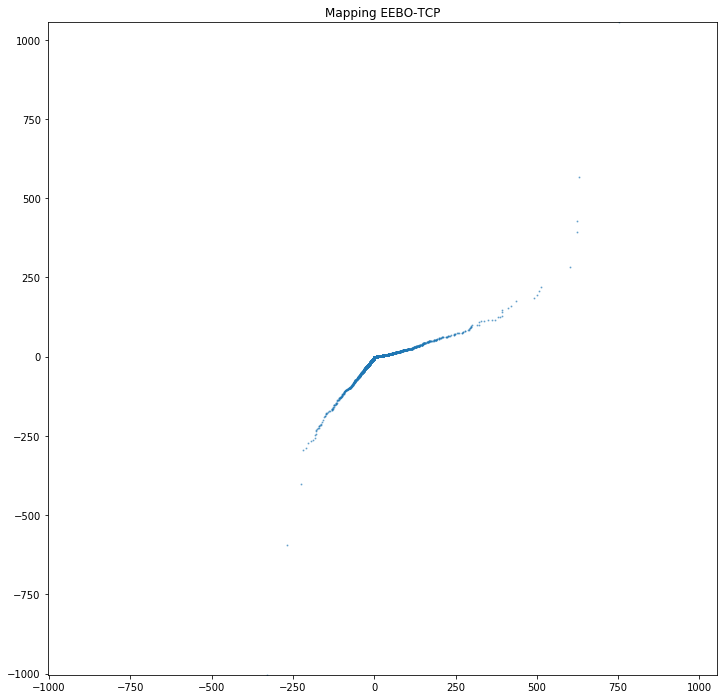

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

plt.title('Mapping EEBO-TCP')

x = []
y = []
for r in results:
    x.append(r['x'])
    y.append(r['y'])

plt.ylim(low_dim, high_dim)
plt.xlim(low_dim, high_dim)

plt.scatter(x, y, s=1, alpha=.5)